In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [ ]:
############################
##### Define Functions #####
############################

def find_n_components(ratios, threshold=0.80):
    cum_var = np.cumsum(ratios)
    if cum_var[-1] < threshold:
        return -1
    n_components = np.argmax(cum_var  >= threshold) + 1
    return n_components

In [3]:
########################
##### Load Dataset #####
########################

df = pd.read_csv("final_data.csv", index_col=0)

In [4]:
#############################################
##### Feature selection and engineering #####
#############################################

X_numeric_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'location_has_non_latin',
'description_has_non_latin', 'requirements_has_non_latin', 'has_requirements',
'has_location', 'has_location_details']
X_text_cols = ['title', 'description_and_requirements']
X_cat_cols = ['country_state']

# location, description, requirements, country will be dropped.
y_col = ['fraudulent']

df2 = df[X_numeric_cols+X_text_cols+X_cat_cols+y_col].dropna()

X = df2[X_numeric_cols+X_text_cols+X_cat_cols]
y = df2[y_col].values.ravel()
X_nontext = df2[X_numeric_cols+X_cat_cols]

In [5]:
##############################
##### Data preprocessing #####
##############################

# Create and fit TfidfVectorizer
preprocessor_text = ColumnTransformer(
    transformers=[
        ("title_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "title"),
        ("dnr_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "description_and_requirements"),
        ("cat_encoded", OneHotEncoder(max_categories=None, handle_unknown='ignore', sparse_output=True), X_cat_cols)
    ],
    remainder='drop'
)

preprocessor_all = ColumnTransformer(
    transformers=[
        ("title_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "title"),
        ("dnr_vectorized", TfidfVectorizer(max_features=5000, stop_words='english'), "description_and_requirements"),
        ("num_scaled", MinMaxScaler(), X_numeric_cols),
        ("cat_encoded", OneHotEncoder(max_categories=None, handle_unknown='ignore', sparse_output=True), X_cat_cols)
    ],
    remainder='drop'
)

X_text_processed = preprocessor_text.fit_transform(X)
X_all_processed = preprocessor_all.fit_transform(X)

In [6]:
#######################
##### PCA and SVD #####
#######################

pca_text = PCA(n_components=3000, random_state=42)
svd_text = TruncatedSVD(n_components=3000, random_state=42)
pca_all = PCA(n_components=3000, random_state=42)
svd_all = TruncatedSVD(n_components=3000, random_state=42)

X_text_pca = pca_text.fit_transform(X_text_processed)
X_all_pca = pca_all.fit_transform(X_all_processed)
X_text_svd = svd_text.fit_transform(X_text_processed)
X_all_svd = svd_all.fit_transform(X_all_processed)

ratios_text_pca = pca_text.explained_variance_ratio_
ratios_all_pca = pca_all.explained_variance_ratio_
ratios_text_svd = svd_text.explained_variance_ratio_
ratios_all_svd = svd_all.explained_variance_ratio_

cum_ratios_text_pca = np.cumsum(ratios_text_pca)
cum_ratios_all_pca = np.cumsum(ratios_all_pca)
cum_ratios_text_svd = np.cumsum(ratios_text_svd)
cum_ratios_all_svd = np.cumsum(ratios_all_svd)

/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: divide by zero encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: overflow encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: invalid value encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: divide by zero encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: overflow encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/uti

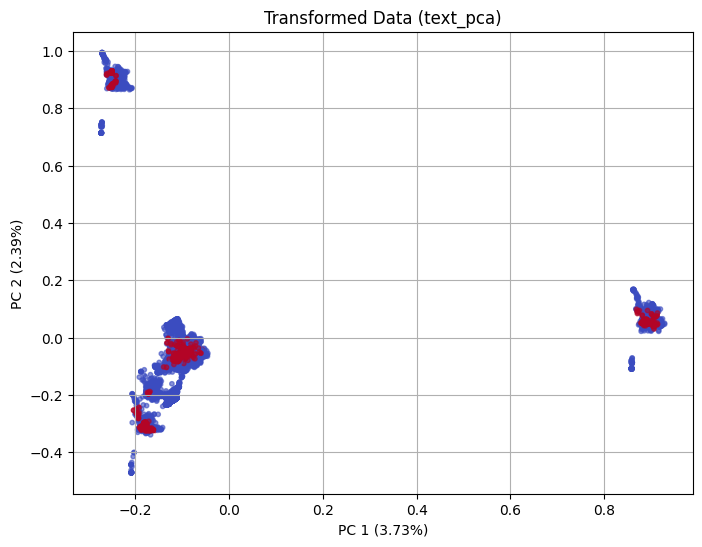

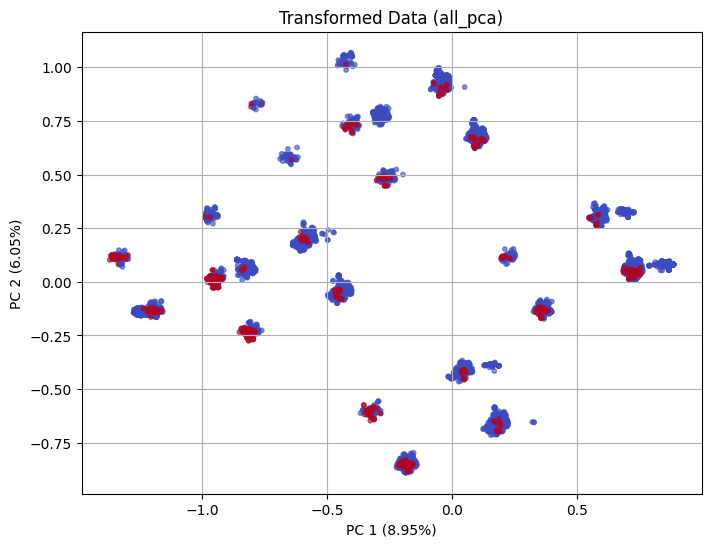

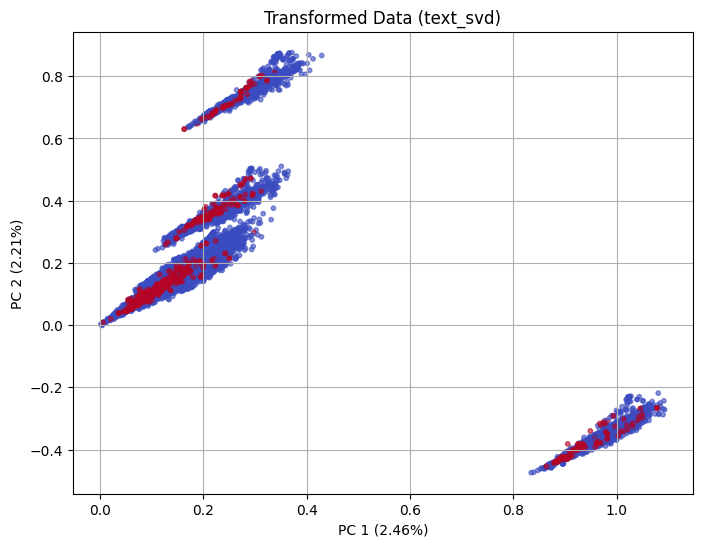

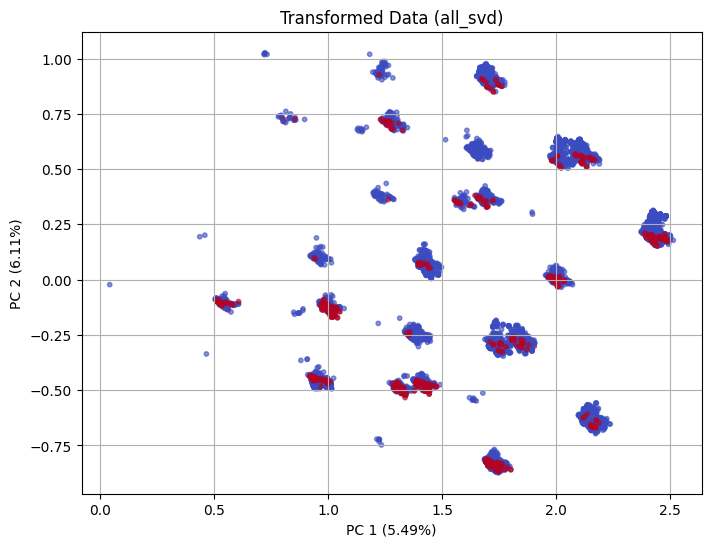

In [ ]:
############################
##### Plot PCA and SVD #####
############################

title_lst = ["text_pca", "all_pca", "text_svd", "all_svd"]
ratios_lst = [ratios_text_pca, ratios_all_pca, ratios_text_svd, ratios_all_svd]
model_lst = [X_text_pca, X_all_pca, X_text_svd, X_all_svd]:
for i, model in enumerate(model_lst):
    plt.figure(figsize=(8, 6))
    plt.scatter(model[:, 0], model[:, 1],
                c=y,             
                cmap='coolwarm',  
                alpha=0.6,
                s=10)
    plt.xlabel(f"PC 1 ({ratios_lst[i][0]*100:.2f}%)")
    plt.ylabel(f"PC 2 ({ratios_lst[i][1]*100:.2f}%)")
    plt.title(f"Transformed Data ({title_lst[i]})")
    plt.grid(True)
    plt.show()

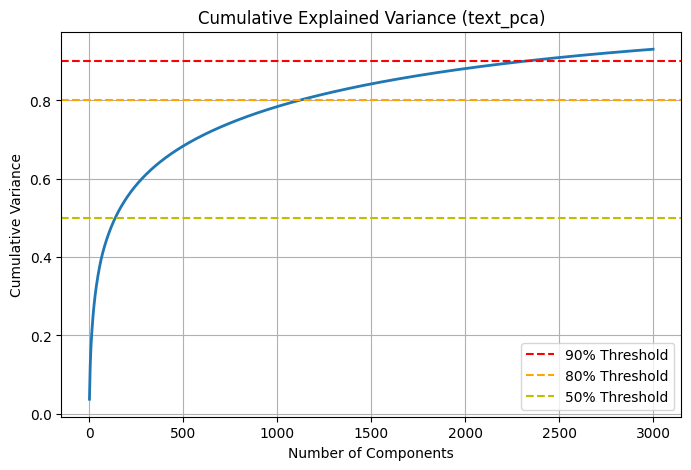

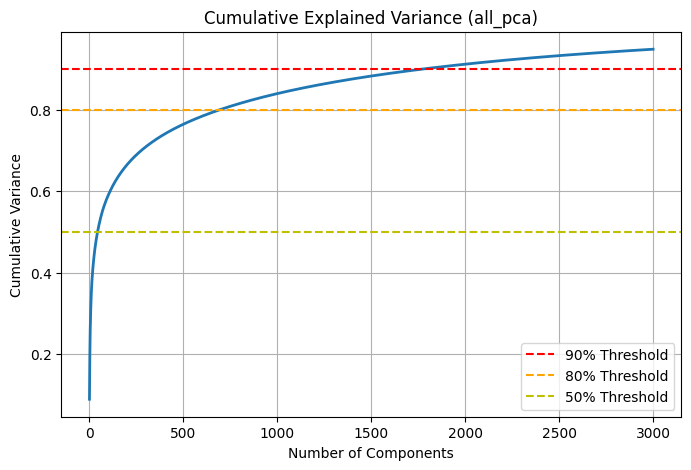

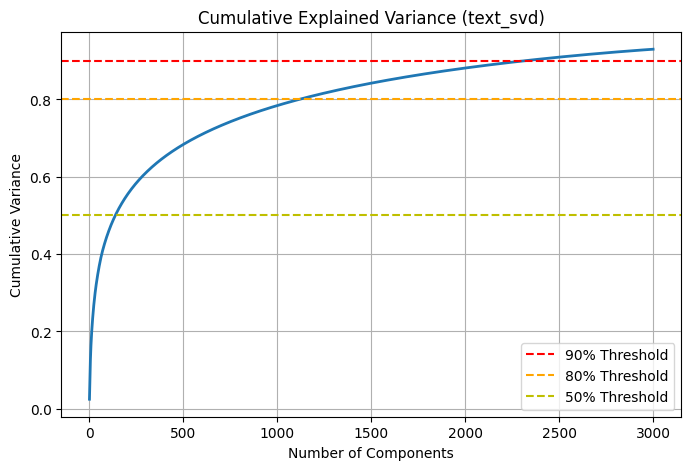

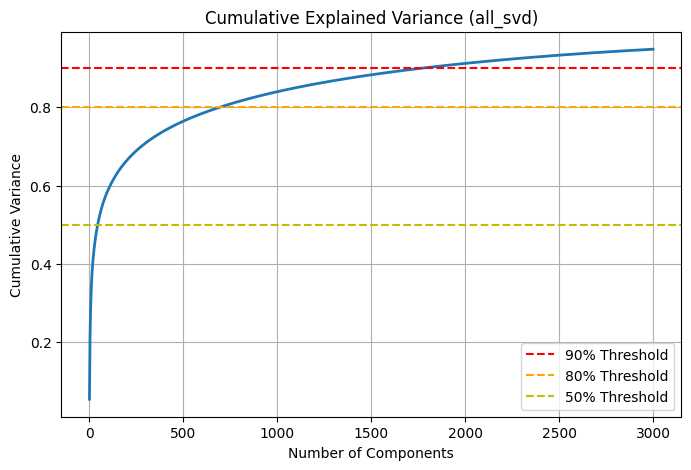

In [10]:
##########################################
##### Cumulative Explained Variances #####
##########################################

title_lst = ["text_pca", "all_pca", "text_svd", "all_svd"]
for i, cum_ratios in enumerate([cum_ratios_text_pca, cum_ratios_all_pca, cum_ratios_text_svd, cum_ratios_all_svd]):
    plt.figure(figsize=(8, 5))
    plt.plot(cum_ratios, linewidth=2)
    plt.axhline(y=0.90, color='r', linestyle='--', label='90% Threshold')
    plt.axhline(y=0.90, color='orange', linestyle='--', label='90% Threshold')
    plt.axhline(y=0.50, color='y', linestyle='--', label='50% Threshold')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Variance')
    plt.title(f'Cumulative Explained Variance ({title_lst[i]})')
    plt.legend()
    plt.grid()
    plt.show()

In [17]:
#####################################################
##### Dimension Size for 50, 80, 90% Thresholds #####
#####################################################

n_lst = []
model_ratios = [ratios_text_pca, ratios_all_pca, ratios_text_svd, ratios_all_svd]
for r in model_ratios:
    n50 = find_n_components(r, 0.50)
    n80 = find_n_components(r, 0.80)
    n90 = find_n_components(r, 0.90)
    n_lst.append([n50, n80, n90])
for i in range(len(n_lst)):
    print(n_lst[i])

[np.int64(139), np.int64(1116), np.int64(2315)]
[np.int64(44), np.int64(695), np.int64(1777)]
[np.int64(139), np.int64(1116), np.int64(2316)]
[np.int64(45), np.int64(695), np.int64(1777)]


In [19]:
################################################
##### PCA and SVD models for 80% Threshold #####
################################################

n1, n2, n3, n4 = [row[1] for row in n_lst]

pca_text_80 = PCA(n_components=n1, random_state=42)
svd_text_80 = TruncatedSVD(n_components=n2, random_state=42)
pca_all_80 = PCA(n_components=n3, random_state=42)
svd_all_80 = TruncatedSVD(n_components=n4, random_state=42)

pca_text_80.fit(X_text_processed)
pca_all_80.fit(X_all_processed)
svd_text_80.fit(X_text_processed)
svd_all_80.fit(X_all_processed)

/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: divide by zero encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: overflow encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: invalid value encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: divide by zero encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: overflow encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/uti

,n_components,np.int64(695)
,algorithm,'randomized'
,n_iter,5
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,42
,tol,0.0


In [20]:
################################################
##### PCA and SVD models for 90% Threshold #####
################################################

n1, n2, n3, n4 = [row[2] for row in n_lst]

pca_text_90 = PCA(n_components=n1, random_state=42)
svd_text_90 = TruncatedSVD(n_components=n2, random_state=42)
pca_all_90 = PCA(n_components=n3, random_state=42)
svd_all_90 = TruncatedSVD(n_components=n4, random_state=42)

pca_text_90.fit(X_text_processed)
pca_all_90.fit(X_all_processed)
svd_text_90.fit(X_text_processed)
svd_all_90.fit(X_all_processed)

/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: divide by zero encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: overflow encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:736: RuntimeWarning: invalid value encountered in matmul
  matvec=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: divide by zero encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/utils/sparsefuncs.py:737: RuntimeWarning: overflow encountered in matmul
  matmat=lambda x: X @ x - offset @ x,
/Users/woojungyi/Library/Python/3.12/lib/python/site-packages/sklearn/uti

,n_components,np.int64(1777)
,algorithm,'randomized'
,n_iter,5
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,42
,tol,0.0


In [21]:
import pickle

model_dict_80 = {
    "text_pca": pca_text_80,
    "all_pca": pca_all_80,
    "text_svd": svd_text_80,
    "all_svd": svd_all_80
}
model_dict_90 = {
    "text_pca": pca_text_90,
    "all_pca": pca_all_90,
    "text_svd": svd_text_90,
    "all_svd": svd_all_90
}

# Save the model (80%)
for title, model in model_dict_80.items():
    filename = f"models/unsupervised_{title}_80.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
# Save the model (90%)
for title, model in model_dict_90.items():
    filename = f"models/unsupervised_{title}_90.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)